In [ ]:
import math
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, BatchNormalization, Conv1DTranspose, AveragePooling1D, UpSampling1D
from tensorflow.keras.regularizers import l2
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from joblib import dump, load
import gc

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Data

In [ ]:
train_dataset = pd.read_csv("/gdrive/My Drive/Colab Notebooks/REHS/drug_target_data/datasets/reduced_train_dataset.csv")
print("Read training data. Now reading testing data")
test_dataset = pd.read_csv("/gdrive/My Drive/Colab Notebooks/REHS/drug_target_data/datasets/reduced_test_dataset.csv")
print("Done reading data")

Read training data. Now reading testing data
Done reading data


In [ ]:
train_labels = train_dataset.pop('label')
test_labels = test_dataset.pop('label')

In [ ]:
train_dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3008,3009,3010,3011,3012,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3026,3027,3028,3029,3030,3031,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047
0,3.231405,-0.045862,-0.022416,2.188148,5.042382,-2.500537,-0.595225,-0.127535,-5.056285,1.806547,0.956628,3.583673,3.130158,6.077588,9.967122,3.852089,6.675878,9.182552,5.927512,5.347445,4.927097,4.430238,-16.500594,-12.697268,-3.731467,11.469455,11.702154,24.620758,-0.772405,2.051831,-0.374071,-1.047108,-1.780478,-0.982952,-2.394727,1.879334,1.236719,2.344369,11.880148,7.9569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.338595,-0.045862,-0.022416,-1.591852,-7.504718,-8.500537,-0.595225,-0.127535,-8.056285,-6.313453,-2.043372,-3.416327,-0.869842,-4.522412,-7.132878,-2.157911,-3.114122,-14.237448,-8.772488,-7.152555,-4.982903,-3.629762,3.899406,-4.397268,29.398533,-27.730545,-28.897846,-47.679242,-2.772405,-3.948169,-0.374071,-0.047108,-1.780478,-6.982952,-0.394727,-2.830666,-0.523281,-8.955631,-15.019852,-1.4131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.301405,-0.045862,-0.022416,3.398148,15.042382,3.499463,-0.595225,-0.127535,10.943715,-0.393453,-2.043372,-2.416327,-0.869842,-1.552412,-2.632878,-1.017911,-1.704122,-3.117448,-2.242488,-1.822555,-1.842903,-1.509762,0.499406,-7.497268,1.578533,-3.130545,-3.897846,-3.479242,-1.772405,-2.948169,-0.374071,-0.047108,-1.780478,3.017048,-0.394727,-1.210666,-0.523281,-3.225631,0.980148,-1.4131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-5.378595,-0.045862,-0.022416,-2.451852,-6.367618,-8.500537,1.404775,-0.127535,7.943715,0.106547,-1.043372,-1.416327,-0.869842,-2.112412,-5.892878,-1.570911,-2.556122,-6.717448,-4.922488,-5.552555,-1.932903,-1.619762,-21.100594,-4.997268,-0.651467,-8.230545,-8.797846,-15.479242,1.227595,-1.948169,-0.374071,0.952892,5.219522,-6.982952,0.605273,-2.830666,-0.523281,-8.622631,-11.839852,-1.4131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.471405,-0.045862,-0.022416,0.558148,-3.857618,-2.500537,-0.595225,-0.127535,-8.056285,2.206547,0.956628,-3.416327,0.130158,0.097588,0.677122,-0.507911,-0.634122,1.582552,0.117512,0.417445,-0.902903,-0.619762,12.099406,-11.297268,-4.537467,3.369455,3.002154,6.320758,0.227595,-2.948169,-0.374071,-1.047108,0.219522,1.017048,-0.394727,0.589334,-0.523281,-5.555631,-2.019852,-1.4131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23282,-0.358595,-0.045862,-0.022416,-0.455852,-6.735618,-2.500537,0.404775,-0.227535,-8.056285,-1.273453,0.956628,-1.416327,-0.869842,-2.412412,-4.792878,-1.376911,-2.367122,-5.817448,-3.822488,-3.892555,-2.482903,-2.219762,22.699406,-12.997268,-3.591467,-10.130545,-9.697846,-18.979242,-1.772405,-1.948169,-0.374071,-1.047108,2.219522,-0.982952,0.605273,1.099334,-0.523281,-4.595631,-7.629852,-1.4131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23283,0.76140

Creating validation dataset. Using stratify option to ensure that there are an equal number of each class in both datasets.

In [ ]:
train_feat, val_feat, train_labels, val_labels = train_test_split(train_dataset, train_labels, test_size=0.3, stratify=train_labels, random_state=9032003)

In [ ]:
train_feat.shape

(16300, 3048)

# Machine Learning Model


In [ ]:
def calc_metrics(train_labels=None, train_pred=None, test_labels=None, test_pred=None):
  """
  Calculates and prints the Binary Crossentropy, AUC, and accuracy of a model.
  """
  c = keras.metrics.BinaryCrossentropy()
  test_loss = c(test_labels, test_pred).numpy()
  if train_labels is not None:
    train_loss = c(train_labels, train_pred).numpy()
    print(f"Train loss: {train_loss}\nTest Loss: {test_loss}")
  else:
    print(f"Test Loss: {test_loss}")

  a = keras.metrics.AUC(num_thresholds=1000)
  test_auc = a(test_labels, test_pred).numpy()
  if train_labels is not None:
    train_auc = a(train_labels, train_pred).numpy()
    print(f"\nTrain auc: {train_auc}\nTest auc: {test_auc}")
  else:
    print(f"Test auc: {test_auc}")

  acc = keras.metrics.BinaryAccuracy()
  test_acc = acc(test_labels, test_pred).numpy()
  if train_labels is not None:
    train_acc = acc(train_labels, train_pred).numpy()
    print(f"\nTrain acc: {train_acc}\nTest acc: {test_acc}")
  else:
    print(f"Test acc: {test_acc}")

In [ ]:
def check_acc_thresh(pred, labels, max_val=10):
  """
  Calculates the accuracy of the model at different thresholds for the outputs and plots them
  """
  accs = []
  for t in [0.1*j for j in range(1, max_val+1)]:
    acc = keras.metrics.BinaryAccuracy(threshold=t)
    accs.append(acc(labels, pred).numpy())

  plt.title('Accuracy vs Accuracy Threshold')
  plt.ylabel('Accuracy')
  plt.xlabel('Threshold')
  plt.plot([10*j for j in range(1, max_val+1)], accs)
  plt.show()
  print(f"Maximum accuracy: {max(accs)} at a threshold of {10*(accs.index(max(accs))+1)}")

In [ ]:
def create_dataset(feat, labels, batch_size):
  ds = tf.data.Dataset.from_tensor_slices((feat, labels))
  ds = ds.repeat().shuffle(feat.shape[0]).batch(batch_size).prefetch(1)
  return ds

compute_steps_per_epoch = lambda x, b: int(math.ceil(x / b))
reshape_cnn_data = lambda ds: ds.to_numpy().reshape((ds.shape[0], ds.shape[1], 1))

In [ ]:
def roc_plot(feat, labels, model=None, pred=None, title=None, file_path=None):
  """
  plots the roc curve of a keras model
  """
  if pred is None:
    pred = model.predict(feat).ravel()
  
  fpr, tpr, thresh = roc_curve(labels, pred)
  auc = roc_auc_score(labels, pred)
  plt.plot(fpr, tpr)
  if title is not None:
    plt.title(title)
  plt.legend(['AUC = %0.2f' % auc], loc='lower right')
  if file_path is not None:
    plt.savefig(file_path, dpi=900)
  plt.show()

## Neural Network

Creating datasets with dataset api

In [ ]:
keras.backend.clear_session()

In [ ]:
batch_size=32
train_ds = create_dataset(train_feat, train_labels, batch_size=batch_size)
val_ds = create_dataset(val_feat, val_labels, batch_size=batch_size)

In [ ]:
# building the model
model = keras.Sequential(name='DNN')
model.add(keras.Input(shape=(train_feat.shape[1],)))
model.add(Dense(
    4096, activation='relu', kernel_regularizer=keras.regularizers.l2(l2=0.01)
))
model.add(Dropout(0.5))
model.add(Dense(
    4096, activation='relu', kernel_regularizer=keras.regularizers.l2(l2=0.01)
))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

# compiling the model
model.compile(
  loss='binary_crossentropy', 
  optimizer=keras.optimizers.Adam(learning_rate=0.00001), 
  metrics=[keras.metrics.AUC(num_thresholds=500), keras.metrics.BinaryAccuracy(threshold=0.5)],
)

#keras.utils.plot_model(model, to_file="dnn_model.png", show_layer_names=False, dpi=1500)

In [ ]:
# building the model
model2 = keras.Sequential(name='CNN')
model2.add(keras.Input(shape=(train_feat.shape[1], 1), name='Input'))
model2.add(Conv1D(16, 3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(2))
model2.add(Conv1D(32, 3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(2))
model2.add(Conv1D(64, 3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(2))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(
    2048, activation='relu', kernel_regularizer=keras.regularizers.l2(l2=0.01)
))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid', name='output'))

# compiling the model
model2.compile(
  loss='binary_crossentropy', 
  optimizer=keras.optimizers.Adam(learning_rate=0.00001), 
  metrics=[keras.metrics.AUC(num_thresholds=500), keras.metrics.BinaryAccuracy(threshold=0.5)]
)

# keras.utils.plot_model(model2, to_file="cnn_model.png", show_layer_names=False, dpi=1500)

In [ ]:
# stopping the training early if the validation loss does not increase for over 3 epochs
callback = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
            # tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=compute_steps_per_epoch(train_feat.shape[0], batch_size),
    epochs=200,
    validation_data=val_ds,
    validation_steps=compute_steps_per_epoch(val_feat.shape[0], batch_size),
    callbacks=[callback],
)

Epoch 1/200
510/510 [==============================] - 10s 18ms/step - loss: 77.3165 - auc_1: 0.5521 - binary_accuracy: 0.5406 - val_loss: 70.8958 - val_auc_1: 0.7640 - val_binary_accuracy: 0.6898
Epoch 2/200
510/510 [==============================] - 9s 17ms/step - loss: 70.4793 - auc_1: 0.6463 - binary_accuracy: 0.6087 - val_loss: 65.4010 - val_auc_1: 0.8120 - val_binary_accuracy: 0.7451
Epoch 3/200
510/510 [==============================] - 9s 17ms/step - loss: 65.1292 - auc_1: 0.6910 - binary_accuracy: 0.6497 - val_loss: 60.9592 - val_auc_1: 0.8203 - val_binary_accuracy: 0.7543
Epoch 4/200
510/510 [==============================] - 9s 17ms/step - loss: 60.5544 - auc_1: 0.7198 - binary_accuracy: 0.6694 - val_loss: 56.8956 - val_auc_1: 0.8366 - val_binary_accuracy: 0.7711
Epoch 5/200
510/510 [==============================] - 9s 17ms/step - loss: 56.7062 - auc_1: 0.7213 - binary_accuracy: 0.6706 - val_loss: 53.4886 - val_auc_1: 0.8270 - val_binary_accuracy: 0.7660
Epoch 6/200
510/510

In [ ]:
# reshaping data to work with convolutional network
conv_train_ds = create_dataset(
    reshape_cnn_data(train_feat), 
    train_labels,
    batch_size)
conv_val_ds = create_dataset(
    reshape_cnn_data(val_feat), 
    val_labels,
    batch_size)

In [ ]:
history = model2.fit(
    conv_train_ds,
    steps_per_epoch=compute_steps_per_epoch(train_feat.shape[0], batch_size),
    epochs=200,
    validation_data=conv_val_ds,
    validation_steps=compute_steps_per_epoch(val_feat.shape[0], batch_size),
    callbacks=[callback],
)

Epoch 1/200
510/510 [==============================] - 19s 34ms/step - loss: 37.7536 - auc_3: 0.5821 - binary_accuracy: 0.5640 - val_loss: 32.2012 - val_auc_3: 0.8098 - val_binary_accuracy: 0.7305
Epoch 2/200
510/510 [==============================] - 17s 34ms/step - loss: 30.9708 - auc_3: 0.7206 - binary_accuracy: 0.6682 - val_loss: 26.8825 - val_auc_3: 0.8440 - val_binary_accuracy: 0.7711
Epoch 3/200
510/510 [==============================] - 17s 34ms/step - loss: 25.9270 - auc_3: 0.7727 - binary_accuracy: 0.7103 - val_loss: 22.7959 - val_auc_3: 0.8603 - val_binary_accuracy: 0.7354
Epoch 4/200
510/510 [==============================] - 17s 34ms/step - loss: 21.9780 - auc_3: 0.7966 - binary_accuracy: 0.7308 - val_loss: 19.4612 - val_auc_3: 0.8704 - val_binary_accuracy: 0.7868
Epoch 5/200
510/510 [==============================] - 17s 34ms/step - loss: 18.8317 - auc_3: 0.8173 - binary_accuracy: 0.7498 - val_loss: 16.8308 - val_auc_3: 0.8701 - val_binary_accuracy: 0.7460
Epoch 6/200
510

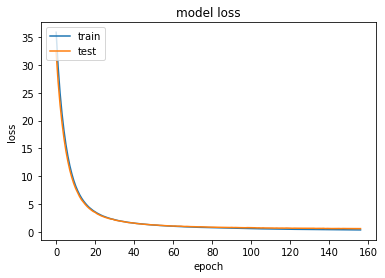

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

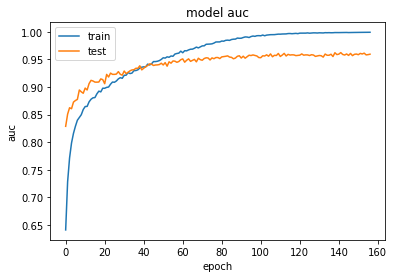

In [ ]:
# summarize history for auc
plt.plot(history.history['auc_29'])
plt.plot(history.history['val_auc_29'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

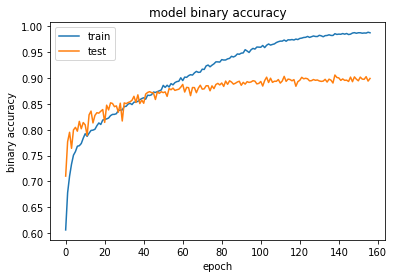

In [ ]:
# summarize history for bin acc
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model binary accuracy')
plt.ylabel('binary accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# model 1 metrics (DNN)
metrics = model.evaluate(val_feat, val_labels)

print(f"Test Loss: {metrics[0]}")
print(f"Test AUC: {metrics[1]}")
print(f"Test Binary Acc: {metrics[2]}")

219/219 [==============================] - 1s 6ms/step - loss: 0.6016 - auc_27: 0.9301 - binary_accuracy: 0.8559
Test Loss: 0.6015745401382446
Test AUC: 0.9301238656044006
Test Binary Acc: 0.8558751940727234


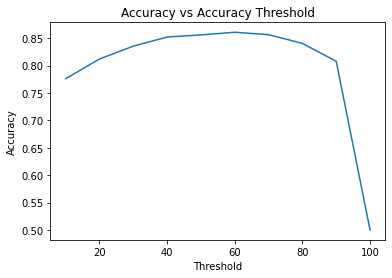

Maximum accuracy: 0.860741376876831 at a threshold of 60


In [ ]:
check_acc_thresh(model.predict(val_feat), val_labels)

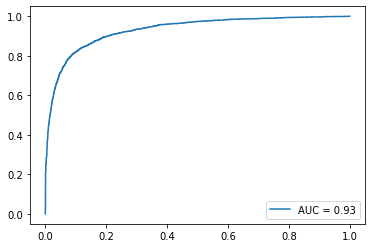

In [ ]:
roc_plot(val_feat, val_labels, model=model)

In [ ]:
# model 2 metrics (CNN)
metrics2 = model2.evaluate(reshape_cnn_data(val_feat), val_labels)

print(f"Test Loss: {metrics2[0]}")
print(f"Test AUC: {metrics2[1]}")
print(f"Test Binary Acc: {metrics2[2]}")

219/219 [==============================] - 3s 12ms/step - loss: 0.3901 - auc_29: 0.9913 - binary_accuracy: 0.9685
Test Loss: 0.39011144638061523
Test AUC: 0.9912758469581604
Test Binary Acc: 0.9685129523277283


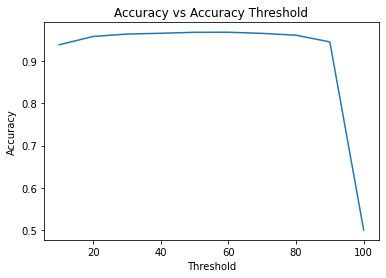

Maximum accuracy: 0.968656063079834 at a threshold of 60


In [ ]:
check_acc_thresh(model2.predict(reshape_cnn_data(val_feat), val_labels)

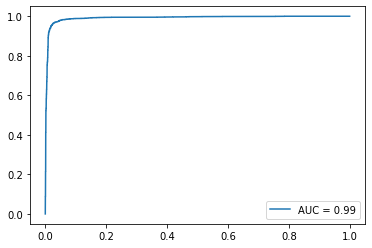

In [ ]:
roc_plot(val_feat.to_numpy().reshape((val_feat.shape[0], val_feat.shape[1], 1)), val_labels, model=model2)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest = RandomForestClassifier(n_estimators=100,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                verbose=1)

In [ ]:
forest.fit(train_feat, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Train loss: 0.1988517791032791
Test Loss: 0.30685582756996155

Train auc: 0.9936942458152771
Test auc: 0.9546312689781189

Train acc: 0.9444376230239868
Test acc: 0.8889365792274475


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


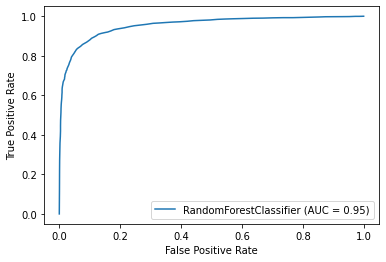

In [ ]:
# calculating metrics
train_forest_pred = forest.predict_proba(train_feat)[:, 1]
val_forest_pred = forest.predict_proba(val_feat)[:, 1]

calc_metrics(train_labels, train_forest_pred, val_labels, val_forest_pred)
# the validation roc plot
plot_roc_curve(forest, val_feat, val_labels)

# Testing on Test Data

Testing the CNN and Random Forest models to compare them.

In [ ]:
model2 = keras.models.load_model('/gdrive/My Drive/Colab Notebooks/REHS/models/model2CNN')

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Test Loss: 0.3148428797721863
Test auc: 0.9496488571166992
Test acc: 0.8876866102218628


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


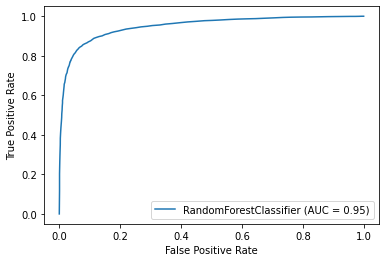

In [ ]:
# testing the RandomForest Classifier
test_forest_pred = forest.predict_proba(test_dataset)[:, 1]

calc_metrics(test_labels=test_labels, test_pred=test_forest_pred)
# the validation roc plot
plot_roc_curve(forest, test_dataset, test_labels)

312/312 [==============================] - 2s 8ms/step - loss: 0.6009 - auc_29: 0.9540 - binary_accuracy: 0.8949
Test Loss: 0.6009401679039001
Test AUC: 0.9539773464202881
Test Binary Acc: 0.8949003219604492


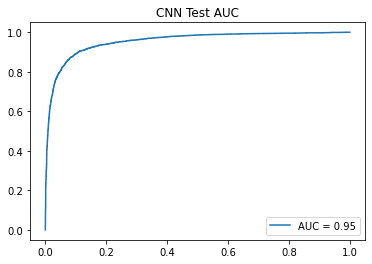

In [ ]:
# CNN (model 2) metrics
test_metrics2 = model2.evaluate(reshape_cnn_data(test_dataset), test_labels)

print(f"Test Loss: {test_metrics2[0]}")
print(f"Test AUC: {test_metrics2[1]}")
print(f"Test Binary Acc: {test_metrics2[2]}")

auc_plot = roc_plot(reshape_cnn_data(test_dataset), test_labels, model=model2, title='CNN Test AUC', file_path='auc_plot_test_cnn.png')